In [10]:
import pickle
import numpy as np
with open('output.pkcl', 'rb') as f:
    d = pickle.load(f)
# Extract the poses with corresponding timestamps from the calibration dataset
stamp = {}
poses = {}
for key in d.keys():
    stamp[key] = np.array([s[0] for s in d[key]])
    poses[key] = np.stack([s[2] for s in d[key]])

In [11]:
from RoboCastingTools.time_sync_utils import getSyncMap
ref_frame = 'Block_3'
# Compute the synchronizing index map between the reference frame and 
# all other frames
maps = {}
for key in stamp.keys():
    if key != ref_frame:
        map = getSyncMap(stamp[ref_frame],stamp[key],threshold=0.01,add_nans=False)
        maps[key] = map

In [12]:
# make a dict to map block names to key IDs and vice versa
name_to_id = {}
id_to_name = {}
for i,key in enumerate(poses.keys()):
    if key.startswith('Block'):
        name_to_id[key]= i
        id_to_name[i] = key


In [13]:
# Use the GTSAM library to find the optimal relative pose between the 
# ref frame and all other frames based on all the relative pose measurements
import gtsam
from gtsam import (
    Pose3,
    Rot3,
    PriorFactorPose3,
    BetweenFactorPose3,
    Point3,
    NonlinearFactorGraph,
    LevenbergMarquardtOptimizer,
)
from gtsam.symbol_shorthand import X

# Create a factor graph
graph = NonlinearFactorGraph()

initial = gtsam.Values()
for key in name_to_id:
    initial.insert(X(name_to_id[key]), gtsam.Pose3())

# Add prior factors for the first two poses
prior_noise = gtsam.noiseModel.Diagonal.Sigmas((0.1, 0.1, 0.1, 0.1, 0.1, 0.1))
graph.add(PriorFactorPose3(X(name_to_id[ref_frame]), Pose3(), prior_noise))

# Add between factors to constrain the poses
between_noise = gtsam.noiseModel.Diagonal.Sigmas((0.01, 0.01, 0.01, 0.01, 0.01, 0.01))

# Add between factor between ref frame and other frames
for key in name_to_id:
    if key != ref_frame:
        ref_pose = poses[ref_frame][maps[key][:,0],...]
        target_pose = poses[key][maps[key][:,1],...]
        for i in range(ref_pose.shape[0]):
            poses[ref_frame][maps[key][:,0],...]
            pose1 = Pose3(ref_pose[0,...])
            pose2 = Pose3(target_pose[0,...])
            between12 = pose1.between(pose2)
            graph.add(BetweenFactorPose3(X(name_to_id[ref_frame]), 
                                         X(name_to_id[key]), 
                                         between12, between_noise))

# Optimize the factor graph
params = gtsam.LevenbergMarquardtParams()
optimizer = LevenbergMarquardtOptimizer(graph,initial,params)
optimized_poses = optimizer.optimize()
#Store the results
results = {}
for key in poses:
    if key.startswith('Block'):
        results[key] = optimized_poses.atPose3(X(name_to_id[key])).matrix()
with open('small_tag_calibrateion.pkl', 'wb') as f:
    pickle.dump(results, f)

In [14]:
results

{'Block_0': array([[ 1.38443567e-02,  9.99413579e-01,  3.13182331e-02,
          3.52188461e-01],
        [-9.99740217e-01,  1.44024568e-02, -1.76654524e-02,
          1.80464300e-01],
        [-1.81061525e-02, -3.10655303e-02,  9.99353341e-01,
          8.59055744e-04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 'Block_1': array([[ 0.01220344, -0.99915809, -0.03916865, -0.34677551],
        [ 0.99910463,  0.013771  , -0.04000371,  0.17890405],
        [ 0.04050942, -0.0386454 ,  0.99843153,  0.00711749],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 'Block_2': array([[-0.00845245, -0.99871814, -0.04990621, -0.3458542 ],
        [ 0.99983225, -0.00925179,  0.01580762, -0.21369403],
        [-0.01624908, -0.04976423,  0.9986288 ,  0.00454239],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 'Block_3': array([[ 1.00000000e+00,  3.75060995e-16,  2.90575480e-16,
          1.58858120e-15],
        [-4.4425421

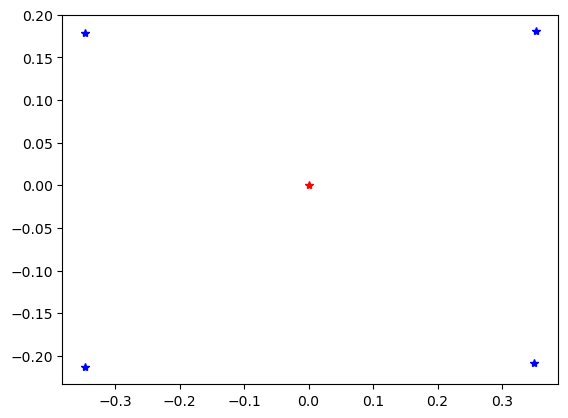

In [15]:
import matplotlib.pyplot as plt
for key in results:
    if key == ref_frame:
        plt.plot(results[key][0,-1], results[key][1,-1], 'r*')
    else:
        plt.plot(results[key][0,-1], results[key][1,-1], 'b*')

In [16]:
tag_size = 0.172


In [18]:
from scipy.spatial.transform import Rotation
with open('bundle_calibration.txt','w') as f:
    for i, key in enumerate(results.keys()):
        q = Rotation.from_matrix(results[f'Block_{i}'][0:3,0:3]).as_quat()
        r = results[key][0:3,-1]        
        f.write(f'{{id: {i}, size: {tag_size}, x: {r[0]:.4f}, y: {r[1]:.4f}, z: {r[2]:.4f}, qw: {q[3]:.7f}, qx: {q[0]:.7f}, qy: {q[1]:.7f}, qz: {q[2]:.7f}}},\n')